# Classifying User Connection Activity

Software to detect network intrusions protects a computer network from unauthorized users. The intrusion detector learning task is to build a classifier, which can distinguish between different types of "bad'' connections, called intrusions or attacks, and normal connections.

A connection is a sequence of TCP packets starting and ending at some well defined times, between which data flows to and from a source IP address to a target IP address under some well defined protocol. Each connection is labeled as either normal, or as an attack, with exactly one specific attack type.

The task will be evaluated using Macro F-score measure.

The dataset is adapted from KDD-CUP-99 contest.

In [ ]:
# import main libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# set axiss' sizes
plt.style.use('ggplot')
plt.rcParams["figure.figsize"]=[12,12]

import time
# import model performance measures
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# import ordinal encoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

# import our model
from sklearn.ensemble import RandomForestClassifier
# import Grid Search
from sklearn.model_selection import GridSearchCV


## Data Manipulation

[link text](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [ ]:
# uploading data

data_train=pd.read_csv('training.csv')
data_test=pd.read_csv('testing.csv')

In [ ]:
data_train.head()

,Id,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
0,1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,114,7,0.0,0.0,1.0,1.0,0.06,0.08,0.00,255,7,0.03,0.06,0.00,0.00,0.0,0.0,1.0,1.0,0
1,2,0,icmp,ecr_i,SF,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,0
2,3,0,tcp,http,SF,302,1023,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,9,0.0,0.0,0.0,0.0,1.00,0.00,0.22,255,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1
3,4,0,udp,ntp_u,SF,48,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,111,9,0.08,0.02,0.08,0.00,0.0,0.0,0.0,0.0,1
4,5,0,tcp,http,SF,334,2096,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,8,0.0,0.0,0.0,0.0,1.00,0.00,0.25,32,255,1.00,0.00,0.03,0.03,0.0,0.0,0.0,0.0,1


In [ ]:
data_test.head()

,Id,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,1,12275,udp,other,SF,146,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,3,0.01,0.63,0.94,0.00,0.0,0.0,0.0,0.0
1,2,5065,udp,other,SF,147,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,1,0.00,0.86,1.00,0.00,0.0,0.0,0.0,0.0
2,3,0,udp,private,SF,105,147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,237,0.93,0.01,0.00,0.00,0.0,0.0,0.0,0.0
3,4,0,tcp,http,SF,309,2637,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,10,10,0.0,0.0,0.0,0.0,1.0,0.0,0.00,255,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
4,5,0,tcp,http,SF,213,1908,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,15,19,0.0,0.0,0.0,0.0,1.0,0.0,0.16,15,255,1.00,0.00,0.07,0.02,0.0,0.0,0.0,0.0


In [ ]:
# Drop 'Id' column (we don't need it)

data_train=data_train.drop(columns='Id')
data_test=data_test.drop(columns='Id')

In [ ]:
# seperating X and y

X=data_train.iloc[:,:-1]
y=data_train.iloc[:,-1:]

In [ ]:
# Check The Shapes Of Dataframes

print(X.shape[1]==data_test.shape[1])
print(y.shape)
print(X.shape)
print(data_test.shape)

True
(449940, 1)
(449940, 41)
(150060, 41)


In [ ]:
X.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,114,7,0.0,0.0,1.0,1.0,0.06,0.08,0.00,255,7,0.03,0.06,0.00,0.00,0.0,0.0,1.0,1.0
1,0,icmp,ecr_i,SF,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0
2,0,tcp,http,SF,302,1023,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,9,0.0,0.0,0.0,0.0,1.00,0.00,0.22,255,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
3,0,udp,ntp_u,SF,48,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,111,9,0.08,0.02,0.08,0.00,0.0,0.0,0.0,0.0
4,0,tcp,http,SF,334,2096,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,8,0.0,0.0,0.0,0.0,1.00,0.00,0.25,32,255,1.00,0.00,0.03,0.03,0.0,0.0,0.0,0.0


In [ ]:
# Merge train and test data for future encodeing and normalisation

data=pd.concat([X,data_test],axis=0)
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,114,7,0.0,0.0,1.0,1.0,0.06,0.08,0.00,255,7,0.03,0.06,0.00,0.00,0.0,0.0,1.0,1.0
1,0,icmp,ecr_i,SF,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,511,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0
2,0,tcp,http,SF,302,1023,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,9,0.0,0.0,0.0,0.0,1.00,0.00,0.22,255,255,1.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
3,0,udp,ntp_u,SF,48,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,111,9,0.08,0.02,0.08,0.00,0.0,0.0,0.0,0.0
4,0,tcp,http,SF,334,2096,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,8,0.0,0.0,0.0,0.0,1.00,0.00,0.25,32,255,1.00,0.00,0.03,0.03,0.0,0.0,0.0,0.0


In [ ]:
data.shape

(600000, 41)

In [ ]:
# Choose categorical columns for further encodeing

categorical_columns = data.select_dtypes(exclude=['int','float']).columns
categorical_columns

Index(['protocol_type', 'service', 'flag'], dtype='object')

In [ ]:
# Lets see what we got

for categorical_column in categorical_columns:
  print(np.unique(data[categorical_column], return_counts=True))

(array(['icmp', 'tcp', 'udp'], dtype=object), array([199955, 334785,  65260]))
(array(['IRC', 'X11', 'Z39_50', 'aol', 'auth', 'bgp', 'courier',
       'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u',
       'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp',
       'ftp_data', 'gopher', 'harvest', 'hostnames', 'http', 'http_2784',
       'http_443', 'http_8001', 'icmp', 'imap4', 'iso_tsap', 'klogin',
       'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm',
       'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u',
       'other', 'pm_dump', 'pop_2', 'pop_3', 'printer', 'private',
       'red_i', 'remote_job', 'rje', 'shell', 'smtp', 'sql_net', 'ssh',
       'sunrpc', 'supdup', 'systat', 'telnet', 'tftp_u', 'tim_i', 'time',
       'urh_i', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois'],
      dtype=object), array([   141,     41,     71,      2,    749,     82,     75,     76,
           99,     83,     88,    109,  17193,     93,  13962,

In [ ]:
# data encodeing

data=pd.get_dummies(data,prefix=categorical_columns)

In [ ]:
data.shape

(600000, 123)

In [ ]:
# Normalisation

data_mean = data.mean()
data_std = data.std()
data = (data - data_mean) / data_std

In [ ]:
# lets see if if we have any NaN

np.any(np.isnan(data))

True

In [ ]:
np.where(np.isnan(data))

(array([     0,      1,      2, ..., 599997, 599998, 599999]),
 array([16, 16, 16, ..., 16, 16, 16]))

In [ ]:
# Solving 'NaN' problem

data = data.dropna(axis=1)
np.any(np.isnan(data))

False

In [ ]:
# Seperating training data for further operations

train_size = X.shape[0]
X_1 = data.iloc[:train_size,:]
y_1 = np.ravel(y) # labels

In [ ]:
print(X_1.shape)
print(y_1.shape)

(449940, 122)
(449940,)


# Getting The Best Parameters For Random Forest Classifier (Fine Tuning)

In [ ]:
# Getting the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_1,
                                                    y_1,
                                                    random_state = 0)

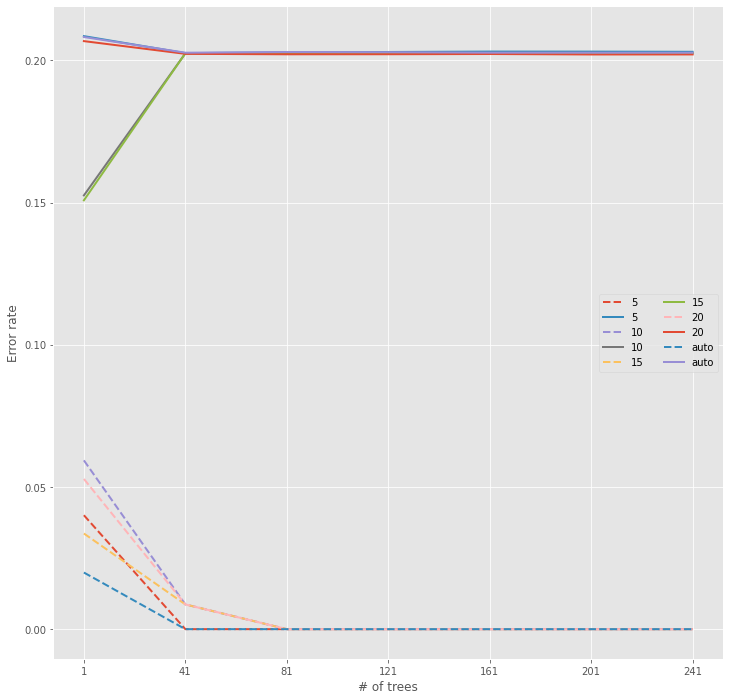

In [ ]:
ensemble_sizes = range(1, 281, 40)
for nr_features in [5, 10, 15, 20, 'auto']:
    
    error_rates = {'train':[], 'test':[]}

    for i in ensemble_sizes:
        model = RandomForestClassifier(n_estimators = i,
                                       random_state = 0,
                                       max_features=nr_features)

        model.fit(X_train, y_train)

        error_rates['train'].append(
            1 - f1_score(model.predict(X_train), y_train, average = 'macro')
            )
        error_rates['test'].append(
            1 - f1_score(model.predict(X_test), y_test, average = 'macro')
            )
    plt.plot(ensemble_sizes, error_rates['train'],
             label=f'{nr_features}', linestyle='--', linewidth=2)
    plt.plot(ensemble_sizes, error_rates['test'],
             label=f'{nr_features}', linewidth=2)
plt.xlabel('# of trees')
plt.ylabel('Error rate')
plt.xticks(ensemble_sizes)
plt.legend(ncol=2)
plt.show()

Using GridSearch to Find The Best Parameters

In [ ]:
parameters={
    'criterion' : ['entropy','gini'],
    'max_features' : [13,14,15,16,17],
    'max_depth' : [15,20,25]}
model = RandomForestClassifier()
clf = GridSearchCV(model, parameters,
                   scoring='f1_macro', cv=5)
clf.fit(X_1, y_1)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
clf.best_params_

{'criterion': 'entropy', 'max_depth': 25, 'max_features': 14}

Let's See How Our Model Performs

In [ ]:
# use it somewhere, somehow
from sklearn.model_selection import cross_val_score
model = RandomForestClassifier(n_estimators=241, max_depth=25, max_features=14, criterion='entropy')
scores = cross_val_score(model, X_1, y_1, cv=5, scoring='f1_macro')
print(scores)
print(scores.mean())

[0.79723636 0.89799154 0.89621634 0.89598094 0.89787511]
0.877060058697201


Fit All Available Training Data




In [ ]:
model = RandomForestClassifier(n_estimators=241, max_depth=25, max_features=14, criterion='entropy')

In [ ]:
model.fit(X_1,y_1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=25, max_features=14,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=241,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Make Predictions

In [ ]:
prediction_data = data.iloc[train_size:,:]

In [ ]:
prediction_data.shape

(150060, 122)

In [ ]:
predictions = model.predict(prediction_data)

Make A Submittion File ( .csv )

In [ ]:
output = pd.DataFrame({
    'Id' : [i+1 for i in range(len(predictions))],
    'Predicted' : predictions
})

In [ ]:
output.to_csv('submission.csv', index=False)